In [43]:
import gym
import matplotlib.pyplot as plt
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import copy
import pygame
from collections import defaultdict


from blackjackutility import get_total, game_result

In [44]:
def plot_value_function(V):
    """
    plot the estimated value function for blackjack
    Returns:  void plots value function
    Args:
    V: a dictionary of estimated values for blackjack
    """
    #range of player score
    player=[state[0]  for state in  V.keys()]
    max_player=max(player)
    min_player=min(player)
    player_range=np.arange(min_player, 22, 1)
    #range of dealer score
    dealer=[state[1]  for state in  V.keys()]
    max_dealer=max(dealer)
    min_dealer=min(dealer)
    dealer_range=np.arange(min_dealer, 11, 1)
    #empty array for the value function, first access in the players score second  is the dealer, third is if  there  is an ace
    V_plot=np.zeros((21-min_player+1,max_dealer-min_dealer+1,2))
    #create a mesh grid for plotting
    X,Y = np.meshgrid(dealer_range,player_range)

    #populate an array  of values for different  scores not including losing scores
    for (player,dealer,ace),v in V.items():
        if player<=21 and dealer<=21:
            V_plot[player-min_player,dealer-min_dealer,(1*ace)]=V[(player,dealer,ace)]

    #plot surface
    fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': '3d'})
    ax[0].plot_wireframe(X,Y, V_plot[:,:,0])
    ax[0].set_title('no ace')
    ax[0].set_xlabel('dealer')
    ax[0].set_ylabel('player ')
    ax[0].set_zlabel('value function')
    ax[1].plot_wireframe(X,Y, V_plot[:,:,1])
    ax[1].set_title('no ace')
    ax[1].set_xlabel('dealer')
    ax[1].set_ylabel('player ')
    ax[1].set_zlabel('value function')
    ax[1].set_title(' ace')
    fig.tight_layout()
    plt.show()

    #plot top view of the surface
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow((V_plot[:,:,0]),extent =[1,10,21,4])
    ax[0].set_title('no ace')
    ax[0].set_xlabel('dealer')
    ax[0].set_ylabel('player ')
    im=ax[1].imshow(V_plot[:,:,1],extent =[1,10,21,4])
    ax[1].set_title('ace')
    ax[1].set_xlabel('dealer')
    fig.colorbar(im, ax=ax[1])

In [45]:
def plot_policy_blackjack(policy):
    """
    plot the policy for blackjack
    Returns:  void plots policy function
    Args:
    policy: a dictionary of estimated values for blackjack
    """
    #range of player score
    player=[state[0]  for state in  policy.keys()]
    max_player=max(player)
    min_player=min(player)
    #this vale is use in RL book
    #min_player=12
    player_range=np.arange(min_player, 22, 1)
    #range of dealer score
    dealer=[state[1]  for state in policy.keys()]
    max_dealer=max(dealer)
    min_dealer=min(dealer)
    dealer_range=np.arange(min_dealer, 11, 1)
    #empty array for the value function, first access in the players score second  is the dealer, third is if  there  is an ace
    policy_plot=np.zeros((21-min_player+1,max_dealer-min_dealer+1,2))
    #create a mesh grid for plotting
    X,Y = np.meshgrid(dealer_range,player_range)


    #populate an array  of values for different  policy not including losing states above 21
    for (player,dealer,ace),v in policy.items():
        if player<=21 and dealer<=10 and player>=min_player:
            policy_plot[player-min_player,dealer-min_dealer,(1*ace)]=policy[(player,dealer,ace)]


    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow((policy_plot[:,:,0]),cmap=plt.get_cmap('GnBu', 2),extent =[1,10,21,4])
    ax[0].set_title('no ace')
    ax[0].set_xlabel('dealer')
    ax[0].set_ylabel('player ')


    ax[1].set_title('ace')
    ax[1].set_xlabel('dealer')
    im=ax[1].imshow(policy_plot[:,:,1],extent =[1,10,21,4],cmap=plt.get_cmap('GnBu', 2))
    fig.colorbar(im, ax=ax[1],ticks=[0 , 1])

In [46]:
def average_wins(environment,policy=None,episodes=10):
    """
    This function calculates the average number of wins for a game of blackjack given a policy.
    If no policy is provided a random policy is selected.
    Returns: average_wins: the average number of wins
    std_wins: the average number of wins
    Args:
    environment:AI gym balckjack envorment object
    policy:policy for blackjack if none a random  action will be selected
    episodes: number of episodes
    """

    win_loss=np.zeros(episodes)

    for episode in range(episodes):
        state=environment.reset()
        done=False

        while (not(done)):
            if policy and isinstance(policy[state],np.int64):

                action=policy[state]

            else:
                action=environment.action_space.sample()

            state,reward,done,info=environment.step(action)
        result=game_result(environment,state,show=False)
        if reward==1:
            win_loss[episode]=1
        else:
            win_loss[episode]=0


    average_wins=win_loss.mean()
    std_win=win_loss.std()/np.sqrt(episodes)

    return average_wins ,std_win

In [47]:
environment= gym.make('Blackjack-v1')

In [48]:
environment.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

In [49]:
def random_action(action,epsilon=0.1,n_actions=2):
    '''
    This function takes the best estimated action, eplsilon, and action space
    and returns some action.
    '''
    # generate a random number from 0 to 1.
    number = np.random.rand(1)

    # if number is smaller than 1-epsilon then return best estimated action
    if number<1-epsilon:
        return action
    # if number is bigger or equals to 1-epsilon then return some random action from the action space
    else:
        action=np.random.randint(n_actions)
        return action

In [50]:
def monte_carlo_ES( environment,N_episodes=100000, discount_factor=1,first_visit=True, epsilon =0.1, theta=0.0001):
    """
    plot the policy for blackjack
    Returns:
    policy: a dictionary of estimated policy for blackjack
    V: a dictionary of estimated values for blackjack
    Q: a dictionary of estimated action function
    DELTA: list of deltas for each episode
    Args:
    environment:AI gym balckjack envorment object
    N_episodes:number of episodes
    discount_factor:discount factor
    first_visit: select first-visit MC (Ture) and every-visit MC (False)
    epsilon: epsilon value
    theta:stoping threshold
    """
    #a dictionary of estimated values for blackjack
    V=defaultdict(float)
    #a dictionary of estimated action function for blackjack
    Q=defaultdict(float)
    # number of visits to the action function
    NumberVisitsValue= defaultdict(float)
    # visits to action function
    NumberVisits= defaultdict(float)
    #dictionary  for policy
    policy=defaultdict(float)
    #number  of actions
    number_actions=environment.action_space.n
    #list of max difference between  value functions per  iteration
    DELTA=[]

    for i in range(N_episodes):
        #max difference between  value functions
        delta=0
        #list that stores each state and reward for each episode
        episode=[]
        # reset the  environment for the next episode and find first state
        state=environment.reset()
        #reward for the first state
        reward=0.0
        #flag for end of episodes
        done=False
        #action for the first state
        action=np.random.randint(number_actions)
        #append firt state, reward and action
        episode.append({'state':state , 'reward':reward,'action':action})
        #Past states for signal visit  Monte Carlo
        state_action=[(state,action)]
        #enumerate for each episode
        while not(done):

                #take action and find next state, reward and check if the episode is  done (True)
                (state, reward, done, prob) = environment.step(action)

                #check if a policy for the state exists
                if isinstance(policy[state],np.int64):
                    #obtain action from policy
                    action=int(policy[state])
                    random_action(action,epsilon,number_actions)
                else:
                     #if no policy for the state exists  select a random  action
                    action=np.random.randint(number_actions)
                #add state reward and action to list
                episode.append({'state':state , 'reward':reward,'action':action})
                #add  states action this is for fist visit only
                state_action.append((state,action))
         #reverse list as the return is calculated from the last state
        episode.reverse()
        #append the state-action pairs to a list
        state_action.reverse()


        #determine the return
        G=0

        for t,step in enumerate(episode):

                #check flag for first visit
                G=discount_factor*G+step['reward']
                #check flag for first visit
                if first_visit:
                    #check if the state has been visited before
                    if (step['state'],step['action']) not in set(state_action[t+1:]):

                        #increment counter for action
                        NumberVisits[step['state'],step['action']]+=1
                        #increment counter for value function
                        NumberVisitsValue[step['state']]+=1
                        #if the action function value  does not exist, create an array  to store them
                        if not(isinstance(Q[step['state']],np.ndarray) ):
                            Q[step['state']]= np.zeros((number_actions))

                        #calculate mean of action function Q Value functions V using the  recursive definition of mean
                        Q[step['state']][step['action']]=Q[step['state']][step['action']]+(NumberVisits[step['state'],step['action']]**-1)*(G-Q[step['state']][step['action']])

                        # record the old value of the value function

                        v=V[step['state']]

                        V[step['state']]=V[step['state']]+(NumberVisitsValue[step['state']]**-1)*(G-V[step['state']])
                        #update the policy to select the action fuciton argment with the largest value
                        policy[step['state']]=np.random.choice(np.where(Q[step['state']]==Q[step['state']].max())[0])
                        #find max difference between all value functions per  iteration
                        delta=max(delta,abs(v-V[step['state']]))


                else:
                         #increment counter for action
                        NumberVisits[step['state'],step['action']]+=1
                        #increment counter for value function
                        NumberVisitsValue[step['state']]+=1
                        #if the action function value  does not exist, create an array  to store them
                        if not(isinstance(Q[step['state']],np.ndarray) ):
                            Q[step['state']]= np.zeros((number_actions))

                        #calculate mean of action function Q Value functions V using the  recursive definition of mean
                        Q[step['state']][step['action']]=Q[step['state']][step['action']]+(NumberVisits[step['state'],step['action']]**-1)*(G-Q[step['state']][step['action']])
                        v=V[step['state']]
                        V[step['state']]=V[step['state']]+(NumberVisitsValue[step['state']]**-1)*(G-V[step['state']])
                        ##update the policy to select the action functioon argument with the largest value
                        policy[step['state']]=np.random.choice(np.where(Q[step['state']]==Q[step['state']].max())[0])
                        #find max difference between all value functions per  iteration
                        delta=max(delta,abs(v-V[step['state']]))

        DELTA.append(delta)
        if delta<theta:
            break

    return policy, V, Q,DELTA

In [51]:
 policy, V, Q,DELTA= monte_carlo_ES(environment,N_episodes=20000, discount_factor=1,epsilon = 0.1,first_visit=True,theta=0)

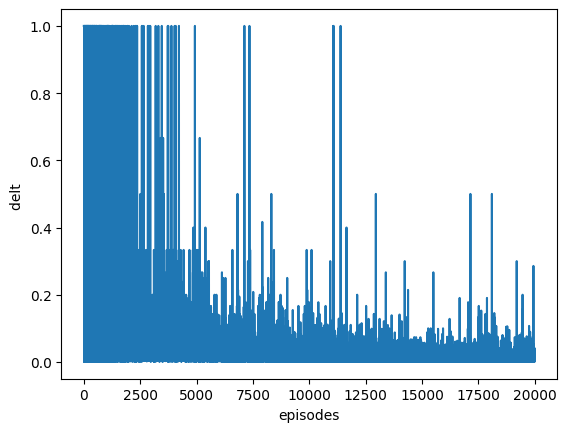

In [52]:
plt.plot(DELTA)
plt.xlabel("episodes")
plt.ylabel("delt ")
plt.show()

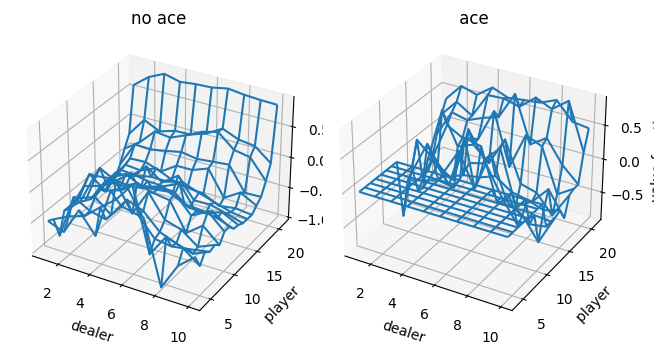

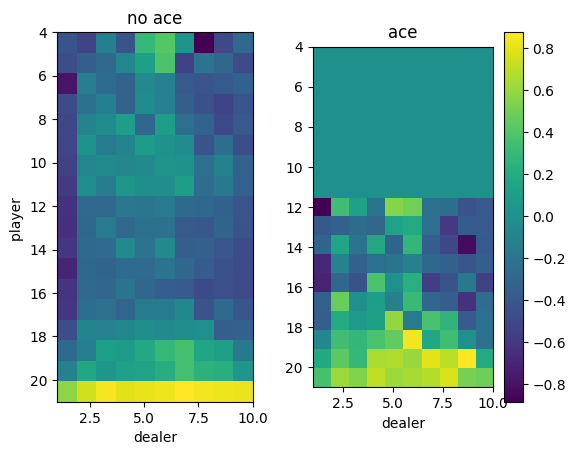

In [53]:
plot_value_function(V)

In [54]:
average ,std_win=average_wins(environment,episodes=10000)
print("average number of wins", average)

average number of wins 0.2817


In [55]:
average ,std_win=average_wins(environment,policy,episodes=10000)
print("average wins:",average,std_win )

average wins: 0.4181 0.004932467840746658


In [56]:
policy, V, Q,DELTA = monte_carlo_ES( environment,N_episodes=50000, discount_factor=1,first_visit=True,theta=0)

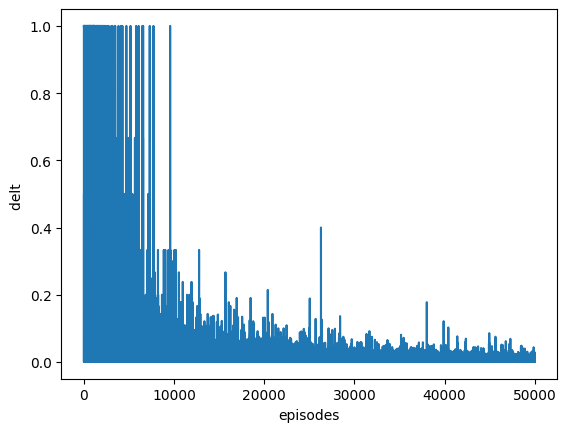

In [57]:
plt.plot(DELTA)
plt.xlabel("episodes")
plt.ylabel("delt ")
plt.show()

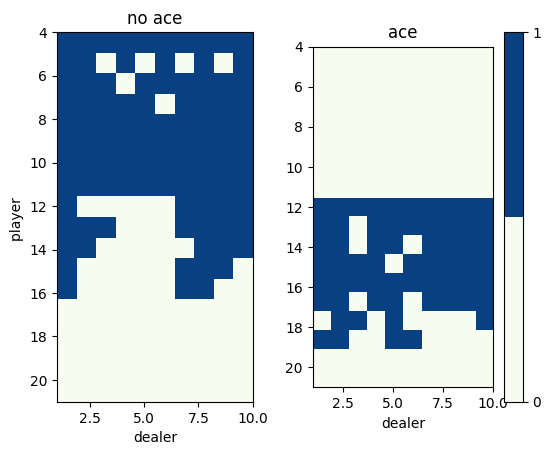

In [58]:
plot_policy_blackjack(policy)

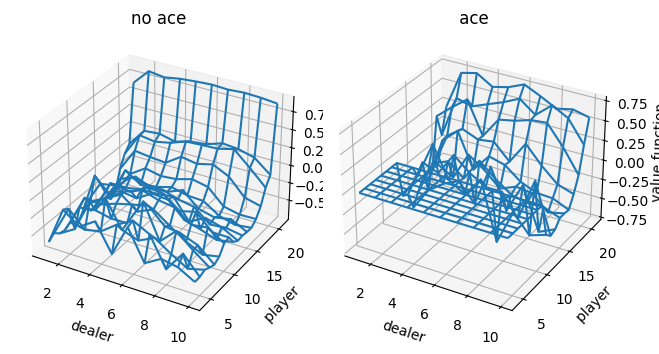

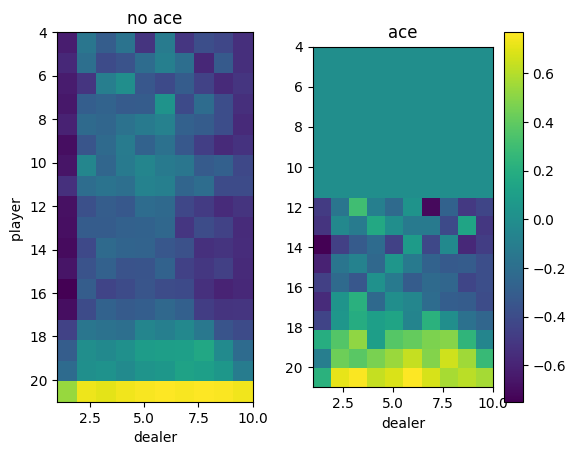

In [59]:
plot_value_function(V)

In [60]:
average ,std_win=average_wins(environment,policy,episodes=10000)
print("average wins:",average,std_win )

average wins: 0.4332 0.004955176687061722


In [61]:
accuracy = []
episodes = []

for n_episode in [1,50,100,500,1000,5000,10000,50000,100000]:
    print("n_episode: ", str(n_episode))
    policy, V, Q, DELTA = monte_carlo_ES( environment,N_episodes=n_episode, discount_factor=1,first_visit=True, theta = 0)
    average ,std_win = average_wins(environment,policy,episodes=10000)
    print("n_episode: ", str(n_episode), " average: ", str(average))
    accuracy.append(average)
    episodes.append(n_episode)

n_episode:  1
n_episode:  1  average:  0.2847
n_episode:  50
n_episode:  50  average:  0.3181
n_episode:  100
n_episode:  100  average:  0.3437
n_episode:  500
n_episode:  500  average:  0.3703
n_episode:  1000
n_episode:  1000  average:  0.3905
n_episode:  5000
n_episode:  5000  average:  0.4142
n_episode:  10000
n_episode:  10000  average:  0.4207
n_episode:  50000
n_episode:  50000  average:  0.4271
n_episode:  100000
n_episode:  100000  average:  0.4308


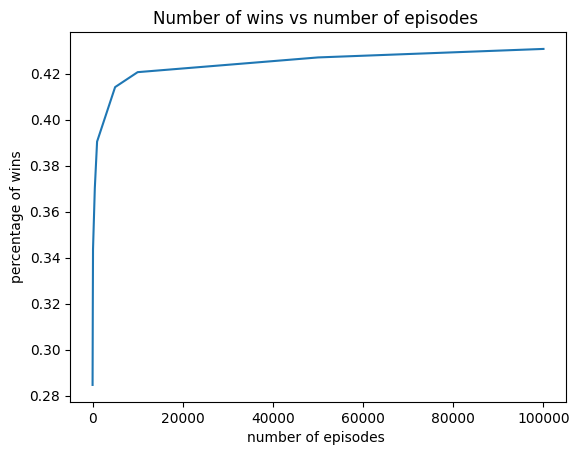

In [62]:
plt.plot(episodes,accuracy)
plt.title("Number of wins vs number of episodes ")
plt.ylabel('percentage of wins')
plt.xlabel('number of episodes ')
plt.show()

In [63]:
accuracy=[]
discounts=[]

for discount in [0,0.01,0.1,0.5,1.0]:
    policy, V, Q, delta = monte_carlo_ES( environment,N_episodes=100000, discount_factor=discount,first_visit=True, theta=0)
    average ,std_win=average_wins(environment,policy,episodes=10000)
    print("discount: ", str(discount), " average: ", str(average))
    discounts.append(discount)
    accuracy.append(average)

discount:  0  average:  0.2803
discount:  0.01  average:  0.3433
discount:  0.1  average:  0.3633
discount:  0.5  average:  0.4276
discount:  1.0  average:  0.4316


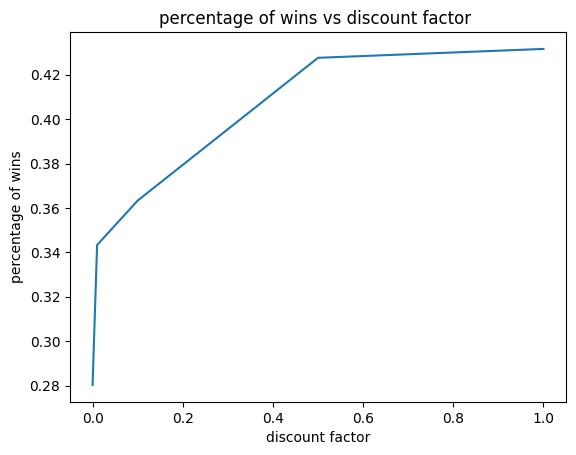

In [64]:
plt.plot(discounts,accuracy)
plt.title("percentage of wins vs discount factor ")
plt.ylabel('percentage of wins')
plt.xlabel('discount factor')
plt.show()